In [1]:
import numpy as np
import pandas as pd
from methods import GuptaPPCA
from methods import GrassPPCA
from methods import KernelPPCA
from methods import binPCA
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
# trainsize = [40, 100, 200]
# ppca = [0.8, 0.5, 0.9]
# grams = [0.13, 0.5, 0.2]

# np.savez("risultati.npz", n = trainsize, ppcaTest = ppca, GrassmanTest = grams)

# results = np.load("risultati.npz")

In [3]:
# results['ppcaTest']

In [4]:
# Number of observations
n = 45
# Dimension
D = 3
# Modes
m = 2

# Functions of the model
def mu_true(par):
    return np.zeros((3,np.shape(par)[0]))

def P_true(par):
    p1_true = np.array([np.sin((7*np.pi/1080)*par+0.4), np.tan((7*np.pi/4860)*par-0.8), (49/1800)*par-1.1])
    p2_true = np.array([np.cos((7*np.pi/972)*par), np.cos((7*np.pi/576)*par-0.4), (7/600)*par+1.4])
    return p1_true,p2_true

In [5]:
# total num. of iteration
n_c = 1000
# num. of iteration for bases
n_v = 500
# orthonormality coeff
lambda_0 = 20
# smoothing coeff
lambda_m = 4.2
lambda_v = 0.008

In [6]:
def fixbins(bins, thetadata, m):
    diff = bins.reshape(-1,1)-thetadata.reshape(1,-1)
    ind = (diff<=0).sum(axis=0)-1
    counts = np.histogram(ind, np.arange(len(bins)))[0]
    jmin = counts.argmin()
    if(counts[jmin]<m):
        newbins = list(bins)
        del newbins[jmin]
        return fixbins(np.array(newbins), thetadata, m)
    else:
        return bins

In [7]:
n_train = 500
split_ratio = 0.4
rmse_PPCA = []
rmse_PCA = []
rmse_SPCA = []
rmse_binPCA = []
rmse_grass = []
rmse_test_PPCA = []
rmse_test_PCA = []
rmse_test_SPCA = []
rmse_test_binPCA = []
rmse_test_grass = []
err_bases_theta = []
err_bases_grass_theta = []
rmse_ker = []
rmse_test_ker = []
training_sizes = np.arange(50,n_train+1,50)
# training_sizes = [5000]
for n in training_sizes:
    print(n)
    # Creating training and test set
    np.random.seed(n)
    ntest = 500
    #theta_sample = np.linspace(0,360,int(n*(1+split_ratio)))
    thetadata = 360*np.random.rand(n) #np.linspace(0,360,n)
    #thetadata_test = np.setdiff1d(theta_sample,thetadata)
    thetadata_test = 360*np.random.rand(ntest) # np.sort(np.random.choice(thetadata_test, (int(n*split_ratio),), replace=False))

    #print(beta[:,0].shape)
    beta = np.random.uniform(-1,1,size=(m, n))
    beta_test = np.random.uniform(-1,1,size=(m, ntest))
    noise = np.random.normal(0,0.5,size=(D, n))
    noise_test = np.random.normal(0,0.5,size=(D, ntest))
    p1_true,p2_true = P_true(thetadata)
    p1_test,p2_test = P_true(thetadata_test)
    xdata = mu_true(thetadata) + p1_true*beta[0] +p2_true*beta[1] + noise
    xdata = xdata.T
    xdata_test = mu_true(thetadata_test) + p1_test*beta_test[0] +p2_test*beta_test[1] + noise_test
    xdata_test = xdata_test.T

    # Bins construction
    nbins = 14
    # 14 equally spaced bins
    bins = np.linspace(0,360,nbins+1)
    bins = fixbins(bins, thetadata, m)

    nbins = len(bins)-1
    # length of each bin
    bin_length = 360/nbins

    # Standard PCA
    pca = PCA(n_components=m)
    data_red_PCA = pca.fit_transform(xdata)
    data_PCA = pca.inverse_transform(data_red_PCA)
    
    proj_test_PCA = pca.transform(xdata_test)
    data_test_PCA = pca.inverse_transform(proj_test_PCA)

    # Sparse PCA
    spca = SparsePCA(n_components=m).fit(xdata)
    spca_transf = spca.transform(xdata)
    data_SPCA = (spca_transf @ spca.components_) + spca.mean_

    proj_test_SPCA = spca.transform(xdata_test)
    data_test_SPCA = (proj_test_SPCA @ spca.components_) + spca.mean_

    # Bins PCA
    binpca = binPCA(bins,m)
    binpca.fit(thetadata,xdata)
    proj_binPCA = binpca.transform(thetadata,xdata)
    data_binPCA = binpca.inverse_transform(thetadata,proj_binPCA)

    proj_test_binPCA = binpca.transform(thetadata_test,xdata_test)
    data_test_binPCA = binpca.inverse_transform(thetadata_test,proj_test_binPCA)

    # PPCA
    gupta = GuptaPPCA(bins,m)
    gupta.fit(thetadata,xdata,maxiter=500,method='Nelder-Mead')
    proj_PPCA = gupta.transform(thetadata,xdata)
    data_PPCA = gupta.inverse_transform(thetadata,proj_PPCA)

    proj_test_PPCA = gupta.transform(thetadata_test,xdata_test)
    data_test_PPCA = gupta.inverse_transform(thetadata_test,proj_test_PPCA)

    # Kernel PCA
    def kernel(theta_new, theta_i, gamma=1/200):
        return np.exp(-gamma*((theta_new-theta_i)**2))
    
    kerpca = KernelPPCA(thetadata,xdata,m, kernel)
    proj_ker = kerpca.transform(thetadata,xdata)
    data_ker = kerpca.inverse_transform(thetadata,proj_ker)

    proj_test_ker = kerpca.transform(thetadata_test,xdata_test)
    data_test_ker = kerpca.inverse_transform(thetadata_test,proj_test_ker)

    # Interpolation PCA
    grass = GrassPPCA(bins,m)
    grass.fit(thetadata,xdata)
    proj_grass = grass.transform(thetadata,xdata)
    data_grass = grass.inverse_transform(thetadata,proj_grass)

    proj_test_grass = grass.transform(thetadata_test,xdata_test)
    data_test_grass = grass.inverse_transform(thetadata_test,proj_test_grass)

    rmse_PPCA.append(np.sqrt(mean_squared_error(xdata, data_PPCA)))
    rmse_PCA.append(np.sqrt(mean_squared_error(xdata, data_PCA)))
    rmse_SPCA.append(np.sqrt(mean_squared_error(xdata, data_SPCA)))
    rmse_binPCA.append(np.sqrt(mean_squared_error(xdata, data_binPCA)))
    rmse_grass.append(np.sqrt(mean_squared_error(xdata, data_grass)))
    rmse_ker.append(np.sqrt(mean_squared_error(xdata, data_ker)))

    rmse_test_PPCA.append(np.sqrt(mean_squared_error(xdata_test, data_test_PPCA)))
    rmse_test_PCA.append(np.sqrt(mean_squared_error(xdata_test, data_test_PCA)))
    rmse_test_SPCA.append(np.sqrt(mean_squared_error(xdata_test, data_test_SPCA)))
    rmse_test_binPCA.append(np.sqrt(mean_squared_error(xdata_test, data_test_binPCA)))
    rmse_test_grass.append(np.sqrt(mean_squared_error(xdata_test, data_test_grass)))
    rmse_test_ker.append(np.sqrt(mean_squared_error(xdata_test, data_test_ker)))

50
100
150
200
250
300
350
400
450
500


In [8]:
# np.savez("resultsBFGS1000.npz", n = training_sizes,
#          pcaTrain = rmse_PCA, pcaTest = rmse_test_PCA, spcaTrain = rmse_SPCA, spcaTest = rmse_test_SPCA, binpcaTrain = rmse_binPCA, binpcaTest = rmse_test_binPCA,
#          ppcaTrain = rmse_PPCA, ppcaTest = rmse_test_PPCA, grassmannTrain = rmse_grass, grassmannTest = rmse_test_grass, kernelTrain = rmse_ker, kernelTest = rmse_test_ker)

In [9]:
def regcoeff(x, y):
    xmean, ymean  = np.mean(x), np.mean(y)
    sxx, sxy = ((x-xmean)**2).sum(), ((x-xmean)*(y-ymean)).sum() 
    b1 = sxy/sxx
    b0 = ymean - b1*xmean
    return b0, b1

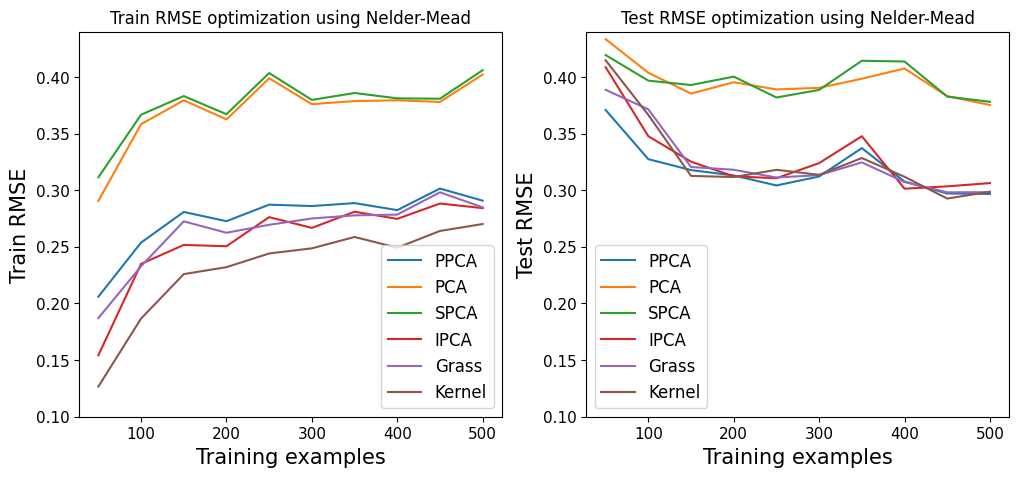

In [19]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(training_sizes,rmse_PPCA, label="PPCA")
plt.plot(training_sizes,rmse_PCA, label="PCA")
plt.plot(training_sizes,rmse_SPCA, label="SPCA")
plt.plot(training_sizes,rmse_binPCA, label="IPCA")
plt.plot(training_sizes,rmse_grass, label="Grass")
plt.plot(training_sizes,rmse_ker, label="Kernel")
plt.ylim(0.1,0.44)
# plt.ylim(-0.01,0.85)
plt.title("Train RMSE optimization using Nelder-Mead")
plt.xlabel("Training examples")
plt.ylabel("Train RMSE")
plt.legend() 
plt.subplot(1,2,2)
plt.plot(training_sizes,rmse_test_PPCA, label="PPCA")
# b0, b1 = regcoeff(training_sizes, rmse_test_PPCA)
# plt.plot(training_sizes, b0 + b1*training_sizes,'--', color = 'steelblue')
plt.plot(training_sizes,rmse_test_PCA, label="PCA")
plt.plot(training_sizes,rmse_test_SPCA, label="SPCA")
plt.plot(training_sizes,rmse_test_binPCA, label="IPCA")
plt.plot(training_sizes,rmse_test_grass, label="Grass")
plt.plot(training_sizes,rmse_test_ker, label="Kernel")
plt.ylim(0.1,0.44)
# plt.xlim(0,10)
plt.title("Test RMSE optimization using Nelder-Mead")
plt.xlabel("Training examples")
plt.ylabel("Test RMSE")
plt.legend() 
plt.show()

In [11]:
def Sdist_inf(A, B):
    U, S, Vh =np.linalg.svd(A.T@B, full_matrices=False)
    return np.sqrt(1-min(S)**2)

In [12]:
# def Sdist_inf(A, B):
#     U, S, Vh =np.linalg.svd(A.T@B, full_matrices=False)
#     angles = np.arccos(np.clip(S,0,1))
    
#     return np.linalg.norm(angles)

In [13]:
dist_bases_PPCA = []
dist_bases_binPCA = []
dist_bases_grassPCA = []
dist_bases_kerPCA = []

In [14]:
for b in np.linspace(0,360,1000):
    P = np.array(P_true(b)).T
    Porth = np.linalg.qr(P)[0]
    # print(Sdist_inf(np.linalg.qr(gupta.predict(b))[0],gupta.predict(b)))
    dist_bases_PPCA.append(Sdist_inf(np.linalg.qr(gupta.predict(b))[0],Porth))
    dist_bases_binPCA.append(Sdist_inf(binpca.predict(b),Porth))
    dist_bases_grassPCA.append(Sdist_inf(grass.predict(b),Porth))
    dist_bases_kerPCA.append(Sdist_inf(kerpca.predict(b),Porth))

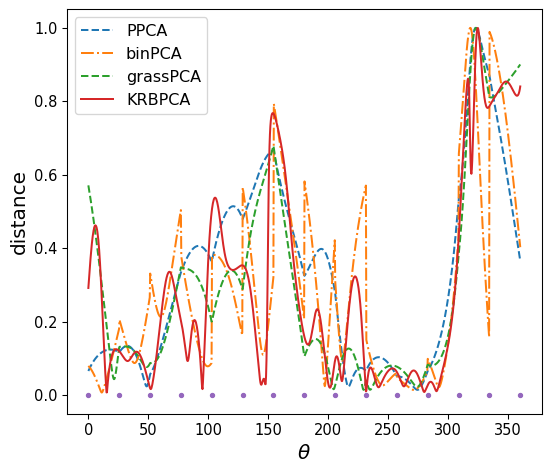

In [15]:
# TEST
my_dpi =96
plt.figure(figsize=(613/my_dpi, 525/my_dpi), dpi=my_dpi)
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=11)    # fontsize of the tick labels
plt.rc('ytick', labelsize=11)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.plot(np.linspace(0,360,1000),dist_bases_PPCA,'--', label="PPCA")
plt.plot(np.linspace(0,360,1000),dist_bases_binPCA,'-.', label="binPCA")
plt.plot(np.linspace(0,360,1000),dist_bases_grassPCA,'--', label="grassPCA")
plt.plot(np.linspace(0,360,1000),dist_bases_kerPCA,'-', label="KRBPCA")
plt.plot(bins,0*bins,'.')
plt.xlabel("$\\theta$",fontsize=15)
plt.ylabel("distance",fontsize=15)
plt.legend()
plt.show()

In [16]:
# # TEST
# my_dpi =96
# plt.figure(figsize=(613/my_dpi, 525/my_dpi), dpi=my_dpi)
# plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=11)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=11)    # fontsize of the tick labels
# plt.rc('legend', fontsize=12)    # legend fontsize
# plt.fill_between(np.linspace(0,360,1000),np.zeros(1000),dist_bases_PPCA, label="PPCA",alpha=0.5)
# plt.fill_between(np.linspace(0,360,1000),np.zeros(1000),dist_bases_binPCA, label="binPCA",alpha=0.5)
# plt.fill_between(np.linspace(0,360,1000),np.zeros(1000),dist_bases_grassPCA, label="grassPCA",alpha=0.5)
# plt.fill_between(np.linspace(0,360,1000),np.zeros(1000),dist_bases_kerPCA, label="KRBPCA",alpha=0.5)
# plt.plot(bins,0*bins,'.')
# plt.xlabel("$\\theta$",fontsize=15)
# plt.ylabel("distance",fontsize=15)
# plt.legend()
# plt.show()

In [17]:
def variability(model,theta_test):
    distances = []
    for i in range(len(theta_test)//2):
        distances.append(Sdist_inf(np.linalg.qr(model.predict(theta_test[2*i]))[0],np.linalg.qr(model.predict(theta_test[2*i+1]))[0]))

    return np.mean(distances), 1.96*np.sqrt(np.var(distances,ddof=1)/(len(theta_test)//2))

In [18]:
print(variability(grass,thetadata_test))
print(variability(kerpca,thetadata_test))
print(variability(binpca,thetadata_test))

(0.6269307261525462, 0.03808070103633852)
(0.642700083626341, 0.038036913837981814)
(nan, nan)


C:\Users\enogj\AppData\Local\Temp\ipykernel_21212\4042723009.py:3: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(1-min(S)**2)
